# 1. Linear regression

<em>Prepared by [Weronika Ormaniec](https://github.com/werkaaa)</em>

Simple [linear regression](https://en.wikipedia.org/wiki/Linear_regression)
 tries to model the dependence between explanatory variable and dependent variable by matching a proper line into the analysed data. Before attepmting to use linear regression one should determine if the variables depend on each other and if their relationship is linear (or may be scaled into a linear one).
![https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png](https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png)
![https://imgs.xkcd.com/comics/linear_regression.png](https://imgs.xkcd.com/comics/linear_regression.png)

Sometimes, linear regression is not a propper approach to the analysed problem.
![https://imgs.xkcd.com/comics/extrapolating.png](https://imgs.xkcd.com/comics/extrapolating.png)

However, it occurs that lots of dependencies in the actual world can be described just by fitting a linear equation to the observed data. That's what we are going to do now!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from livelossplot import PlotLosses
from ipywidgets import interact, fixed
import ipywidgets as widgets

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/Animals.csv", index_col=0)

#### Have you ever wondered what is the relation between brain and body weights among various animal species?
We will try to find a solution to this problem.

In [3]:
data

,BodyWeight(kg),BrainWeight(kg),Brain-to-Body-Weight_Proportion
Species,,,
Newborn_Human,3.20,0.374985,0.117183
Adult_Human,73.00,1.349982,0.018493
Pithecanthropus_Man,70.00,0.925011,0.013214
Squirrel,0.80,0.007620,0.009525
Hamster,0.15,0.001406,0.009374
Chimpanzee,50.00,0.419981,0.008400
Rabbit,1.40,0.011521,0.008229
Dog_(Beagle),10.00,0.071985,0.007199
Cat,4.50,0.029982,0.006663


Let's look at the graph:

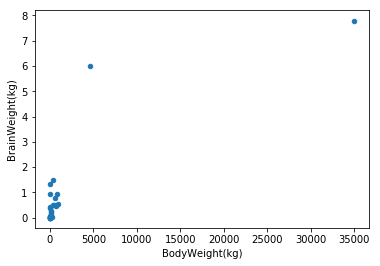

In [4]:
data.plot.scatter(x="BodyWeight(kg)", y="BrainWeight(kg)")

At first glance it does not resemble any particular dependance. However, if we change the scale something interesting can be spotted:

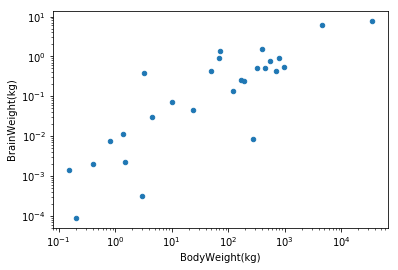

In [5]:
data.plot.scatter(x="BodyWeight(kg)", y="BrainWeight(kg)", logx=True, logy=True)
#plt.scatter(np.log(data['BodyWeight(kg)']), np.log(data['BrainWeight(kg)']))

We can say that the data points form a line. Then, we can try to find the equation of that line.

That is why we need linear regression.

### 1.0 Linear equation

Let's consider two sets of numbers:

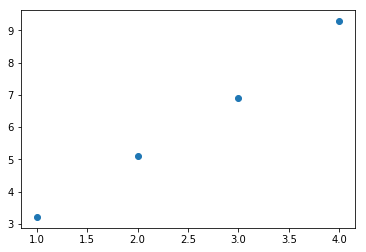

In [6]:
x = [1, 2, 3, 4]
y = [3.2, 5.1, 6.9, 9.3]

plt.scatter(x, y)
plt.show()

On the scatterplot it can be easly seen that the relationship between presented data is almost linear. We will try to apply the equation:

$$ y = w_0 + w_1x $$

to the analysed dataset. The only problem is how to find $w_0$ and $w_1$.

### 1.1 Manual approach

Try to find a proper line manually!

In [7]:
def plot_model(b, a, x, y):
    y_pred = b + a * np.array(x) 
    plt.scatter(x, y)
    plt.plot(x, y_pred, 'g')
    plt.show()
    print('a =', a)
    print('b =', b)
    
interact(plot_model, 
         a=(-2.5, 2.5), 
         b=(-2.5, 2.5),
         x=fixed(x),
         y=fixed(y)
        )

interactive(children=(FloatSlider(value=0.0, description='b', max=2.5, min=-2.5), FloatSlider(value=0.0, descr…

<function __main__.plot_model(b, a, x, y)>

### 1.2 Loss function

We will try to somehow measure if the coefficients in the equation are good enough to describe our problem. In order to do it we will define a loss function - an equation that will tell us how much our approximation differs from the expected output. 

The loss function should:
* depend only on the coefficients of the model, expected output and our approximation,
* shrink if our approximation is becomming better and grow if it gets worse.

When it comes to linear regression the most common approach is the least-squares loss function. We will calculate the average square of the vertical deviations from each data point to the line. Since we first square the dviations, it does not matter if the data point is above or below the line. 


$$y^{ pred}_{i} = ax_{i}+b $$
$$L=\frac{1}{N}\sum_{i=0}^N( y^{pred}_{i} - y_{i})^2 $$

We will get random $a$ and $b$ and apply our loss function.

In [8]:
W = torch.randn(1,2)
X = torch.tensor([[1.0,1.0,1.0,1.0], x])
Y = torch.tensor(y)
print(W)
print(X)
print(Y)

tensor([[-1.1674,  2.0340]])
tensor([[1., 1., 1., 1.],
        [1., 2., 3., 4.]])
tensor([3.2000, 5.1000, 6.9000, 9.3000])


In [9]:
def Y_pred(W, X):
     return W.matmul(X) #matrix multiplication
Y_pred(W, X)

tensor([[0.8666, 2.9006, 4.9346, 6.9686]])

In [10]:
def Loss(W, X, Y):
    y_pred = Y_pred(W, X)
    return ((y_pred-Y)*(y_pred-Y)).mean()
Loss(W, X, Y)

tensor(4.8951)

### 1.3 Minimazing loss function

You will find more detailed explanation of what will happen here in the chapter "Gradient descent".

Since we have defined the loss function, we should minimize it. By doing so we will step by step rotate and move the line, so it will reflect the actual location of data points. In order to do it we need to repeatedly shift the weights till we find a minimum of the loss function. What we need is a mathematical operation that will tell us how the loss function will change, if we increase or decreas $w_0$ and $w_1$. The operation we are looking for is partial derivative.

$$\dfrac{\partial L}{\partial b} = \frac{2}{N}\sum_{i=0}^N (y^{pred}_{i} -y_{i})$$


$$\dfrac{\partial L}{\partial a}  = \frac{2}{N}\sum_{i=0}^N (y^{pred}_{i} -y_{i}) \cdot x_{i}$$ 

In [11]:
def dL_dw0 (W, X, Y):
    y_pred = Y_pred(W, X)
    return 2*(y_pred - Y).mean()
dL_dw0(W, X, Y)

tensor(-4.4148)

In [12]:
def dL_dw1 (W, X, Y):
    y_pred = Y_pred(W, X)
    return 2*((y_pred - Y)*X[1]).mean()
dL_dw1(W, X, Y)

tensor(-10.9770)

Two more thing we have to specify is **learning\_rate** - hyperparamiter that will define how much the value of the derivative will influance the change of $w_0$ and $w_1$ and **num\_epochs** - hyperparameter defining how many iterations it will take to sufficiently minimiaze the loss function.

In [13]:
def gradient_step(W, X, Y, learnig_rate):
    W[0][0]-=learnig_rate*dL_dw0(W, X, Y)
    W[0][1]-=learnig_rate*dL_dw1(W, X, Y)
    return W

In [14]:
def minimise_loss_function(W, X, Y, learning_rate, num_epochs):
    loss_history = []
    for i in range(num_epochs):
        W = gradient_step(W, X, Y, learning_rate)
        loss_history.append(Loss(W, X, Y))
    return W, loss_history

tensor([[-1.1674,  2.0340]])
tensor([[0.4187, 2.2344]]) [tensor(1.2183), tensor(0.7611), tensor(0.5655), tensor(0.5349), tensor(0.4877), tensor(0.4585), tensor(0.4266), tensor(0.3991), tensor(0.3726), tensor(0.3484), tensor(0.3257), tensor(0.3046), tensor(0.2849), tensor(0.2666), tensor(0.2496), tensor(0.2338), tensor(0.2191), tensor(0.2054), tensor(0.1926), tensor(0.1808), tensor(0.1697), tensor(0.1595), tensor(0.1499), tensor(0.1410), tensor(0.1327), tensor(0.1250), tensor(0.1178), tensor(0.1112), tensor(0.1050), tensor(0.0992)]


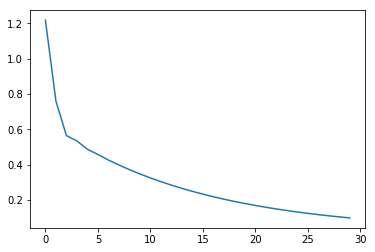

In [15]:
print(W)

learning_rate = 0.1
num_epochs = 30
W_trained, loss_history = minimise_loss_function(W, X, Y, learning_rate, num_epochs)

print(W_trained, loss_history)
plt.plot(list(range(num_epochs)), loss_history)

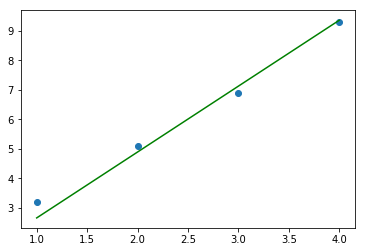

a = 2.2343745
b = 0.41865557


In [16]:
b = W.numpy()[0][0]
a = W.numpy()[0][1]
plot_model(b, a, np.array(x), y)

And that is how we find the propper line!

### 1.4 Linear regression using PyTorch

Knowing how linear regression works, let's come back to the relation between body and brain weights. This time we will use built-in PyTorch functions.

Firstly, we need to prepare the data.

In [17]:
X = torch.tensor(np.log(data['BodyWeight(kg)']))
Y = torch.tensor(np.log(data['BrainWeight(kg)']))
X = X.view(1, 27, 1)
Y = Y.view(1, 27, 1)

Instead of initializing the coefficients manually, we can define the model using a built in class. Since both input and output in the analysed problem have only one dimension we set **(1,1)** as arguments of **nn.Linear**.

In [18]:
model = nn.Linear(1, 1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.0088]], requires_grad=True)
Parameter containing:
tensor([-0.5202], requires_grad=True)


Insted of **gradient\_step** function, we will define an **optimizer** with learning rate and built-int **loss function**.

In [19]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [20]:
loss_function = F.mse_loss
loss = loss_function(model(X), Y)
print(loss)

tensor(12.0268, grad_fn=<MseLossBackward>)


Before training the model, let's see what does the line with random cefficients look like.

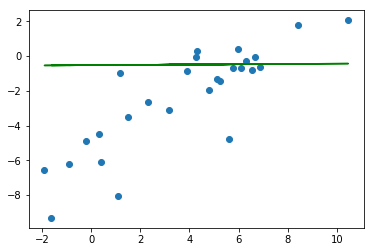

a = 0.008800506591796875
b = -0.52015221118927


In [21]:
X_viewed = X.view(27)
plot_model(model.bias.item(), model.weight.item(), X_viewed.numpy(), Y)

Now we can train the model - minimise the loss function.

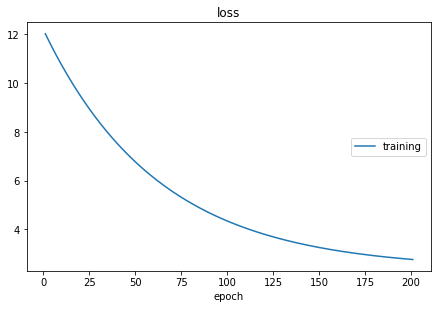

loss:
training   (min:    2.760, max:   12.027, cur:    2.760)
b = -4.406250476837158
a = 0.6343133449554443


In [22]:
liveloss = PlotLosses()

def train(num_epochs, X, Y, model, loss_function, optim):
    loss_history = []
    preds = torch.tensor([])
    for epoch in range(num_epochs):
        
        epoch_loss = 0.0
        
        Y_pred = model(X)
        loss = loss_function(Y_pred, Y)
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        preds = torch.cat([preds, Y_pred], 0)
        
        epoch_loss = loss.data.item()
        
        avg_loss = epoch_loss / len(X)

        liveloss.update({
            'loss': avg_loss
        })
        liveloss.draw()
        print("b =", model.bias[0].item())
        print("a =", model.weight[0][0].item())
        
    return preds

predictions = train(201, X, Y, model, loss_function, optim)


We can see, how the line was changing during learning process:

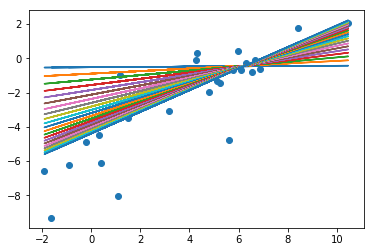

In [23]:
X_viewed = X.view(27)
predictions = predictions.view([-1, 27])
plt.scatter(X, Y)
for i in range(predictions.size()[0]):
    if i%10 == 0:
        plt.plot(X_viewed.numpy(),predictions[i].detach().numpy())
    

Let's see if we fitted the final line properly!

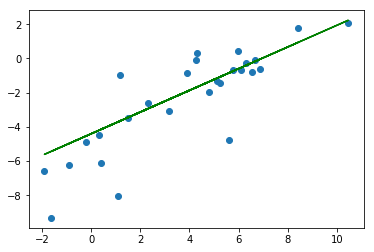

a = 0.6343133449554443
b = -4.406250476837158


In [24]:
X_viewed = X.view(27)
Y_viewed = Y.view(27)
plot_model(model.bias.item(), model.weight.item(), X_viewed.numpy(), Y)

It fits the data much better than at the begining. We have found the relation between brain and body weights among various animal species.

In [25]:
predictions_n = predictions[-1].exp().detach().numpy()
df = pd.DataFrame({'Species'  : data.index, 'PredictedBrainWeight(kg)': predictions_n})
df.index = df["Species"]

In [26]:
data_p = pd.concat([data, df['PredictedBrainWeight(kg)']], axis=1)
data_p

,BodyWeight(kg),BrainWeight(kg),Brain-to-Body-Weight_Proportion,PredictedBrainWeight(kg)
Species,,,,
Newborn_Human,3.20,0.374985,0.117183,0.025679
Adult_Human,73.00,1.349982,0.018493,0.185948
Pithecanthropus_Man,70.00,0.925011,0.013214,0.181073
Squirrel,0.80,0.007620,0.009525,0.010676
Hamster,0.15,0.001406,0.009374,0.003700
Chimpanzee,50.00,0.419981,0.008400,0.146334
Rabbit,1.40,0.011521,0.008229,0.015215
Dog_(Beagle),10.00,0.071985,0.007199,0.052826
Cat,4.50,0.029982,0.006663,0.031864


We can now compare predicted brain weights with actual data. What does it mean that the actual brain weight is bigger than predicted one? Is an animal more clever in that case?

### 1.5 Homework

If you want to practice linear regression, here is another dataset. It describes the relation between weight and average heart rate of various animals. 

(Tip: try to scale the data, by taking logarithm of both values)

In [27]:
data2 = pd.read_csv("data/Heart_rate_and_weight.csv", index_col=0)
data2

,Average Heart Rate (beats per minute),Weight (grams)
Creature,,
Human,60,90000
Cat,150,2000
Small dog,100,2000
Medium dog,90,5000
Large dogs:,75,8000
Hamster,450,60
Chick,400,50
Chicken,275,1500
Monkey,192,5000


### Here are some interesting websites on the subject of linear regression:


* [Linear regression](http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm)
* [Ordinary Least Squares Regression-Explained Visually](http://setosa.io/ev/ordinary-least-squares-regression/)
* [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
